# Import libraries

In [54]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# Others
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Tensorflow dependecies ### 
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

### Some constants ###
data_dir = "../data/DOG_CAT_SMALL/train"
batch_size = 32
d_model = 128
img_size = 64
patch_size = img_size // 4

# Data Loader
The data loader for ViT should be able to :
- [x] Load images and resize them to 64 x 64 dimension.
- [x] Divide each image into 16 16x16 patches (Four patches on each dimension).
- [x] Flatten the patches -> Final dimension = (batch_size, 16, 16*16)

In [55]:
class DataLoader:
    def __init__(self, directory, batch_size=32, split_ratio=0.2,
                 img_size=64, shuffle=True):
        self.directory = directory
        self.shuffle = shuffle
        self.batch_size = batch_size 
        self.split_ratio = 0.2
        self.img_size = img_size
        self.patch_size = img_size // 4
        self.n_classes = 10 # To be adjusted when dataset is parsed
        
        self.train_dataset, self.val_dataset = None, None
        self.train_paths, self.train_labels = None, None
        self.val_paths, self.val_labels = None, None
        
        self.parse_dataset()
        
    def map_fn(self, img, img_size):
        # After the image has been decoded into TF tensor
        # Regular image decoding
        img = tf.image.resize(img, [img_size, img_size])
        img = tf.clip_by_value(img, 0.0, 255.0)
        
        img = img / 127.5 - 1
        
        return img
        
    def parse_fn_with_label(self, path, label):
        img = tf.io.read_file(path)
        img = tf.io.decode_png(img, 3)
        
        img = self.map_fn(img, self.img_size)
        label = tf.one_hot(label, depth=self.n_classes)
        
        return img, label
        
        
    def parse_dataset(self):
        all_imgs = glob.glob(os.path.join(data_dir, "*", "*.jpg"))
        
        img_paths = []
        img_labels = []
        for entry in all_imgs:
            class_name = entry.split('/')[-2]
            
            img_labels.append(class_name)
            img_paths.append(entry)
        
        img_labels = np.array(img_labels)
        img_paths = np.array(img_paths)
        
        img_labels = LabelEncoder().fit_transform(img_labels).flatten()
        
        self.n_classes = len(np.unique(img_labels))
        self.all_paths = img_paths
        self.all_labels = img_labels
        
        # Config sets of train - val img paths and labels
        self.train_paths, self.val_paths, self.train_labels, self.val_labels = train_test_split(
            self.all_paths, self.all_labels, test_size = self.split_ratio)
        
        # Get train and val dataset
        self.train_dataset = self.get_train_dataset()
        self.val_dataset = self.get_val_dataset()
        
    def get_train_dataset(self):
        if(self.train_dataset is None):
            self.train_dataset = tf.data.Dataset.from_tensor_slices((self.train_paths, self.train_labels))
            
            if(self.shuffle):
                self.train_dataset = self.train_dataset.shuffle(40000)
            
            self.train_dataset = self.train_dataset.map(self.parse_fn_with_label)
            self.train_dataset = self.train_dataset.batch(self.batch_size)
            self.train_dataset = self.train_dataset.repeat(1).prefetch(1)
            
        return self.train_dataset
    
    def get_val_dataset(self):
        if(self.val_dataset is None):
            self.val_dataset = tf.data.Dataset.from_tensor_slices((self.val_paths, self.val_labels))
            
            if(self.shuffle):
                self.val_dataset = self.val_dataset.shuffle(40000)
                
            self.val_dataset = self.val_dataset.map(self.parse_fn_with_label)
            self.val_dataset = self.val_dataset.batch(self.batch_size)
            self.val_dataset = self.val_dataset.repeat(1).prefetch(1)
            
        return self.val_dataset
            
    def get_batch(self, train=True):
        if(train):
            images, labels = next(iter(self.train_dataset))
        else:
            images, labels = next(iter(self.val_dataset))
            
        # Flattening images into patches
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        
        return images, patches, labels

In [56]:
# Create a loader and get train dataset
loader = DataLoader(data_dir)
images, patches, labels = loader.get_batch()

print(images.shape)
print(patches.shape)

(32, 64, 64, 3)
(32, 16, 768)


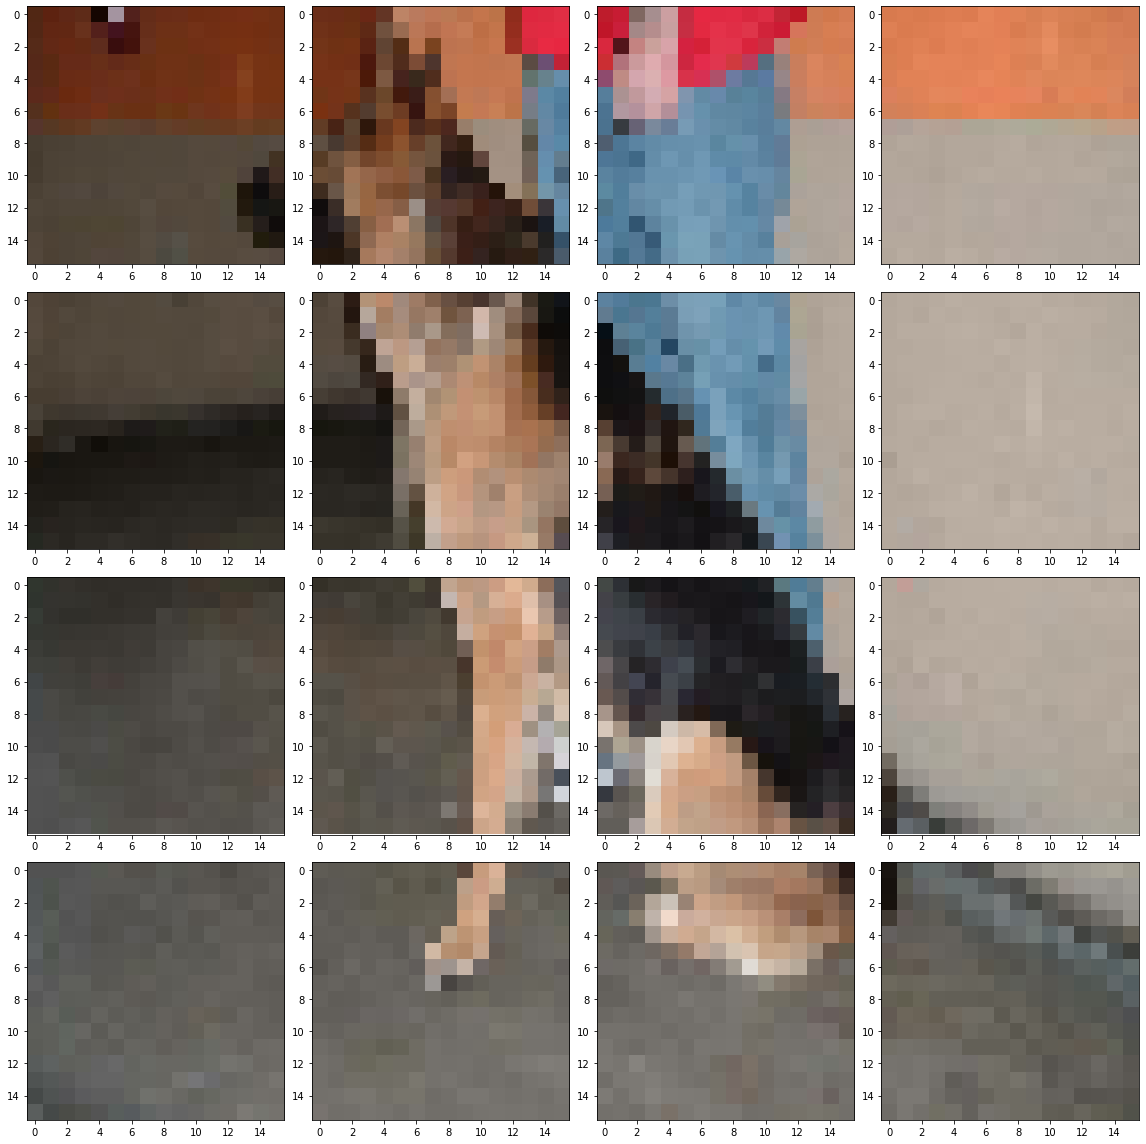

In [57]:
# Visualize sample patches
img = (patches.numpy()[np.random.randint(0, batch_size)] + 1) * 127.5
img = img.reshape(-1, patch_size, patch_size, 3)

fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in range(img.shape[0]):
    row = i // 4
    col = i %  4
    
    patch = img[i].astype(np.uint8)    
    ax[row][col].imshow(patch)
    
plt.tight_layout()
plt.show()

# Vision Transformer
### 1. Positional embedding
- For the sake of simplicity, we use the basic positional embedding only.
- For even position : $PE(pos, 2i) = sin(pos/10000^{2i/d_{model}})$
- For odd  position : $PE(pos, 2i+1) = cos(pos/10000^{2i/d_{model}})$

In [58]:
def pos_embedding_matrix(d_model = 128, seq_len = 16):
    # Get the pos embedding matrix
    pos_embs = []
    
    # Position 0 is reserved for classification token
    for i in range(0, seq_len + 1):
        pos_vec = np.array([x for x in range(1, d_model + 1)])
        even_mask = np.array([1 if x % 2 == 0 else 0 for x in range(1, d_model + 1)])
        odd_mask = np.array([0 if x % 2 == 0 else 1 for x in range(1, d_model + 1)])
        
        pos_even = np.sin(i/(10000 ** (pos_vec / d_model))) * even_mask
        pos_odd = np.cos(i/(10000 ** ((pos_vec - 1) / d_model))) * odd_mask
        
        pos_emb = pos_even + pos_odd
        pos_embs.append(pos_emb)

    return np.array(pos_embs)

pos_embedding_matrix().shape


(17, 128)

### 2. Self-attention and multi-headed attention modules

In [69]:
class SelfAttention(Model):
    def __init__(self, d_model=128):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        
        self.W_q = Dense(d_model, activation='relu')
        self.W_k = Dense(d_model, activation='relu')
        self.W_v = Dense(d_model, activation='relu')
        
    def call(self, x):
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        q_k_T = tf.matmul(Q, tf.transpose(K))
        d_k = tf.cast(self.d_model, dtype=tf.float32)
        
        score = tf.nn.softmax(q_k_T / tf.math.sqrt(d_k)) 
        output = tf.matmul(score, V)
        
        return output
    
attention = SelfAttention()
X = tf.random.normal(shape=(16, 768), dtype=tf.float32)
attention(X)

<tf.Tensor: shape=(16, 128), dtype=float32, numpy=
array([[0.4675455 , 0.22670348, 0.7806182 , ..., 0.4372043 , 0.41789156,
        0.7529271 ],
       [0.44195548, 0.40667918, 0.78676707, ..., 0.34684977, 0.44525486,
        0.90272486],
       [0.32850757, 0.7673393 , 0.86861384, ..., 0.35699654, 0.52771705,
        1.0517445 ],
       ...,
       [0.30401027, 0.50253904, 0.7327963 , ..., 0.4455834 , 0.46331808,
        0.76442736],
       [0.3926676 , 0.5377574 , 0.72865826, ..., 0.37667787, 0.40020755,
        0.84628004],
       [0.36368644, 0.5189054 , 0.80714506, ..., 0.27613074, 0.36249858,
        0.9531126 ]], dtype=float32)>